# Texture Synthesis with Spatial Generative Adversarial Networks

[Paper](https://arxiv.org/pdf/1611.08207v2.pdf)
[Sample implementation](https://github.com/ubergmann/spatial_gan)


In [1]:
import tensorflow as tf
import numpy as np
from nbutil import imshow_multi, to_pil
from tensorflow.contrib.layers.python.layers import batch_norm
from tensorflow.contrib.layers import xavier_initializer
import skimage
import skimage.io
import random

In [2]:
BATCH_SIZE = 16
Z_WIDTH, Z_HEIGHT = (4, 4)
OUTPUT_WIDTH, OUTPUT_HEIGHT = (64, 64)
Z_DEPTH = 20
EPOCH_ITERS = 64 * 100
L2_REG = 1e-5

(425, 640, 3)


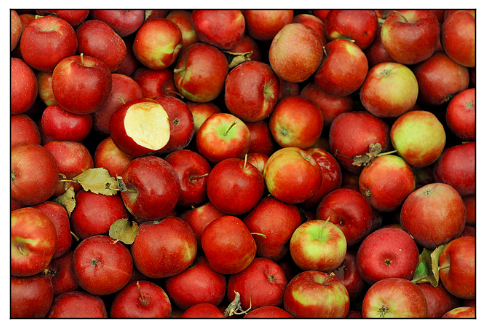

In [3]:
%matplotlib inline

def load_image(path):
    # load image
    img = skimage.io.imread(path)
    img = img[:,:,:3] # drop alpha channel
    return img / 255.0

image = load_image('../data/apples.jpg.1')
print image.shape
imshow_multi([image])


In [4]:
dropout_keep_prob = tf.placeholder_with_default(tf.constant(1.0), [], name='dropout_keep_prob')        

def lrelu(x):
    alpha = 0.1
    return tf.maximum(alpha*x, x)

relu = tf.nn.relu

def concat_elu(x):
    """ like concatenated ReLU (http://arxiv.org/abs/1603.05201), but then with ELU """
    axis = len(x.get_shape())-1
    return tf.nn.elu(tf.concat(axis, [x, -x]))

def concat_lrelu(x):
    axis = len(x.get_shape())-1
    return lrelu(tf.concat(axis, [x, -x]))

def create_batch_norm(inputs, name='bn'):
    with tf.variable_scope(name):
        return batch_norm(inputs, is_training=True, updates_collections=None)

def create_dropout(inputs):
    return tf.nn.dropout(inputs, dropout_keep_prob)

# conv_init =  lambda shape, dtype, partition_info: np.random.rand(*shape) * 0.1
# zero_init = lambda shape, dtype, partition_info: np.random.rand(*shape) * 0
d_init = tf.truncated_normal_initializer(0.0, 0.02)
bias_init = tf.truncated_normal_initializer(0.0, 0.0)
g_init = tf.truncated_normal_initializer(1.0, 0.02)


def create_conv(input, out_channels, patch_size=5, stride=1, init=d_init, name='conv'):
    with tf.variable_scope(name):
        in_channels = input.get_shape()[-1].value
        # w = weight_var([patch_size, patch_size, in_channels, out_channels], name='w', key=join_keys(key, 'w'))
        # b = weight_var([out_channels], stddev=0, name='b', mean=0.1, key=join_keys(key, 'b'))
        w = tf.get_variable('w', 
                            shape=[patch_size, patch_size, in_channels, out_channels], 
                            initializer=init)
        b = tf.get_variable('b',
                           shape=[out_channels],
                           initializer=bias_init)
        conv = tf.nn.conv2d(input, w, strides=[1,stride,stride,1], padding='SAME')
        return conv+b

def create_deconv(input, out_channels, patch_size=5, stride=1, init=g_init, name='deconv'):
    with tf.variable_scope(name):
        # for best results, patch_size should be a multiple of stride
        input_w, input_h, input_channels = [i.value for i in input.get_shape()[-3:]]

        # w = weight_var([patch_size, patch_size, out_channels, input_channels])
        # b = weight_var([out_channels], mean=0.1)
        w = tf.get_variable('w', 
                            shape=[patch_size, patch_size, out_channels, input_channels], 
                            initializer=init)
        b = tf.get_variable('b',
                            shape=[out_channels],
                            initializer=bias_init)

        batch_size = BATCH_SIZE # tf.shape(input)[0]
        output_shape = tf.pack([batch_size, input_w*stride, input_h*stride, out_channels])

        deconv = tf.nn.conv2d_transpose(input, w, output_shape, strides=[1,stride,stride,1], padding='SAME')

        return deconv + b


In [5]:
source_image = tf.constant(image, tf.float32)
def rand_crop(): return tf.random_crop(source_image, [OUTPUT_WIDTH, OUTPUT_HEIGHT, 3])
real_textures = tf.pack([rand_crop() for _ in xrange(BATCH_SIZE)])

old_images = tf.placeholder_with_default(
    tf.zeros([BATCH_SIZE, OUTPUT_WIDTH, OUTPUT_HEIGHT, 3]), 
    [BATCH_SIZE, OUTPUT_WIDTH, OUTPUT_HEIGHT, 3], 
    name='old_images')

# def create_stats_layer(input):
#     mean, variance = tf.nn.moments(input, axes=[0,1,2])
#     variance = tf.reshape(variance, [1, 1, 1, -1])
#     return tf.concat(3, [input, variance])

def generator(image, name='generator'):
    with tf.variable_scope(name):
        layers = [256, 128, 64, 3]
        for i, channels in enumerate(layers):
            is_last = (i == len(layers)-1)
            image = create_deconv(image, channels, patch_size=5, stride=2, name='deconv'+str(i))
            if not is_last:
                image = create_batch_norm(image, name='bn'+str(i))
                image = lrelu(image)
                # image = relu(image)
        print image.get_shape()
        return tf.nn.sigmoid(image)

def discriminator(image, name='discriminator', reuse=False):
    activations = []
    with tf.variable_scope(name, reuse=reuse):
        layers = [64, 128, 256, 1]
        for i, channels in enumerate(layers):
            is_last = (i == len(layers)-1)
            image = create_conv(image, channels, patch_size=5, stride=2, name='conv'+str(i))
            if i > 0:
                image = create_batch_norm(image, name='bn'+str(i))
            if not is_last:
                # image = create_stats_layer(image)
                image = create_dropout(image)
                image = lrelu(image) # concat_lrelu(image)
            activations.append(image)
        # image = create_conv(image, 64, patch_size=1, stride=1, name='final1')
        # image = create_conv(image, 1, patch_size=1, stride=1, name='final2')
        return tf.squeeze(tf.nn.sigmoid(image), 3), activations
        # return image



In [6]:
def compute_disc_output_accuracy(output, target):
    # disc_guess = tf.argmax(output, 3)
    disc_guess = tf.cast(tf.round(output), tf.int32)
    disc_correct = tf.equal(disc_guess, target)
    disc_accuracy = tf.reduce_mean(tf.cast(disc_correct, tf.float32))
    return disc_accuracy

def compute_disc_loss(output, target):
    return tf.nn.l2_loss(output - tf.cast(target, tf.float32))
    # targets = tf.one_hot(target, depth=2, on_value=0.9)
    # return tf.reduce_mean(tf.square(output - targets))
    # return tf.nn.l2_loss(output - targets)
    # return tf.reduce_mean(tf.log(output if is_real else 1-output))
    # print output.get_shape()
    # print targets.get_shape()
    # l2 loss is better for GANs, maybe? https://arxiv.org/abs/1611.04076
    # return tf.nn.l2_loss(output - tf.expand_dims(tf.cast(target, tf.float32), 1))
    # return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(output, targets))
    # return tf.reduce_sum(output)

scopename = '28'

disc_lr = tf.placeholder_with_default(tf.constant(0.0005), [], name='disc_lr')
gen_lr = tf.placeholder_with_default(tf.constant(0.0005), [], name='gen_lr')

with tf.variable_scope(scopename):

    noise = tf.random_uniform([BATCH_SIZE, Z_WIDTH, Z_HEIGHT, Z_DEPTH], minval=-1, maxval=1)
    synthetic_textures = generator(noise)
    
    are_synthetic_textures_real, layer_activations_synth = discriminator(synthetic_textures)
    are_real_textures_real, layer_activations_real = discriminator(real_textures, reuse=True)
    # are_old_synthetics_real = discriminator(old_images, reuse=True)
    
    feature_matching_loss = tf.add_n(
        [tf.nn.l2_loss(tf.reduce_mean(layer_activations_real[l], 0) - tf.reduce_mean(layer_activations_synth[l], 0)) * 0.1 
         for l in [0, -2]]
    )
    
    batch_is_real = tf.ones([BATCH_SIZE, Z_WIDTH, Z_HEIGHT], tf.int32)
    batch_is_fake = tf.zeros_like(batch_is_real)
    
    sets = [(are_synthetic_textures_real, batch_is_fake),
            (are_real_textures_real, batch_is_real)]
            # (are_old_synthetics_real, batch_is_fake)]
    
    disc_loss = tf.add_n([compute_disc_loss(outputs, labels) for outputs, labels in sets]) / len(sets)
    disc_acc = tf.add_n([compute_disc_output_accuracy(outputs, labels) for outputs, labels in sets]) / len(sets)
    
    gen_loss = compute_disc_loss(are_synthetic_textures_real, batch_is_real) + feature_matching_loss
    
#     disc_input = tf.concat(0, [synthetic_textures, real_textures])
#     disc_target = tf.concat(0, [batch_is_fake, batch_is_real])
#     disc_outputs = discriminator(disc_input)
    
#     disc_loss = compute_disc_loss(disc_outputs, disc_target)
#     disc_acc = compute_disc_output_accuracy(disc_outputs, disc_target)
#     gen_loss = -disc_loss
    
    global_step = tf.contrib.framework.get_or_create_global_step()
    
    disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scopename+'/discriminator')
    disc_l2 = tf.add_n([ tf.nn.l2_loss(v) for v in disc_vars ]) * L2_REG
    train_disc = tf.train.AdamOptimizer(disc_lr, beta1=0.5).minimize(disc_l2 + disc_loss, global_step=global_step, var_list=disc_vars)
    
    gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scopename+'/generator')
    gen_l2 = tf.add_n([ tf.nn.l2_loss(v) for v in gen_vars ]) * L2_REG
    train_gen = tf.train.AdamOptimizer(gen_lr, beta1=0.5).minimize(gen_l2 + gen_loss, global_step=global_step, var_list=gen_vars)


(16, 64, 64, 3)


In [7]:
session = tf.InteractiveSession()

save_path = None # 'models/sgan2-128-2'

init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
session.run(init_op)

import os
saver = None
if save_path:
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(save_path)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(session, ckpt.model_checkpoint_path)
        print 'Restored from checkpoint', ckpt.model_checkpoint_path
    else:
        print 'Did not restore from checkpoint'
else:
    print 'Will not save progress'

Will not save progress


In [8]:
%matplotlib inline

def avg(x): return sum(x) / float(len(x))
disc_accuracies = []
old_images_ = [np.zeros([OUTPUT_WIDTH, OUTPUT_HEIGHT, 3]) for _ in xrange(100)]

i = 0

disc_and_gen_trains = [0,0]

while True:
    _, step_, disc_acc_, examples_, loss_ = session.run([train_gen, global_step, disc_acc, synthetic_textures, disc_loss],
                                                        feed_dict={})
    disc_accuracies.append(disc_acc_)
    disc_and_gen_trains[1] += 1
    
    if len(disc_accuracies) > 0 and avg(disc_accuracies) < 0.85:
        selected_old_images = [random.choice(old_images_) for _ in xrange(BATCH_SIZE)]
        _, step_, disc_acc_ = session.run([train_disc, global_step, disc_acc], 
                                          feed_dict={old_images: selected_old_images, dropout_keep_prob: 0.7})
        disc_accuracies.append(disc_acc_)
        disc_and_gen_trains[0] += 1
        # print 'train disc'
    
    old_images_[random.randint(0, len(old_images_)-1)] = examples_[0]
    
    step_rounded = int(step_ / 2) * 2
    if step_rounded % 100 == 0:
        epochs = float(step_) / 2 / EPOCH_ITERS * BATCH_SIZE
        disc_percent = int(disc_and_gen_trains[0] / float(disc_and_gen_trains[1]+1e-8) * 100)
        print "Step: {}, epochs: {}, disc accuracy: {}, loss: {}, disc train %: {}".format(step_, epochs, avg(disc_accuracies), loss_, disc_percent)
        # imshow_multi(examples_[:3])
        disc_accuracies = []
        disc_and_gen_trains = [0,0]
        
        if step_rounded % 200 == 0 and saver:
            should_save = True
            if should_save:
                saver.save(session, save_path + '/model.ckpt', global_step=step_)
                print 'Saved'
            else:
                pass
    i += 1


Step: 100, epochs: 0.125, disc accuracy: 0.71654296875, loss: 31.315782547, disc train %: 99
Step: 200, epochs: 0.25, disc accuracy: 0.82453125, loss: 30.4237976074, disc train %: 99
Step: 201, epochs: 0.25125, disc accuracy: 0.86328125, loss: 30.6535415649, disc train %: 0
Step: 300, epochs: 0.375, disc accuracy: 0.877288510101, loss: 30.4648971558, disc train %: 0
Step: 301, epochs: 0.37625, disc accuracy: 0.88671875, loss: 30.6804962158, disc train %: 0
Step: 400, epochs: 0.5, disc accuracy: 0.874388415404, loss: 30.6531448364, disc train %: 0
Step: 401, epochs: 0.50125, disc accuracy: 0.890625, loss: 30.3509349823, disc train %: 0
Step: 500, epochs: 0.625, disc accuracy: 0.873579545455, loss: 30.8191833496, disc train %: 0
Step: 501, epochs: 0.62625, disc accuracy: 0.880859375, loss: 30.5334033966, disc train %: 0
Step: 600, epochs: 0.75, disc accuracy: 0.870107323232, loss: 30.6251373291, disc train %: 0
Step: 601, epochs: 0.75125, disc accuracy: 0.86328125, loss: 30.4607696533, d

KeyboardInterrupt: 

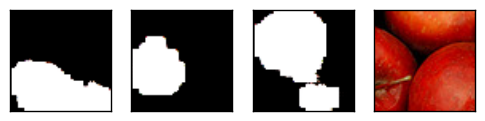

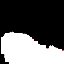

In [9]:
%matplotlib inline
def generate_sample():
    textures, real = session.run([synthetic_textures, real_textures])
    imshow_multi(list(np.clip(textures[:3], 0, 1)) + list(real[:1]))
    return to_pil(textures[0])
generate_sample()